<a href="https://colab.research.google.com/github/AnushkaMazumdar2/Re-inforcement-Learning/blob/main/2348505_Lab5(RL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Necessary Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

Monte Carlo (MC) methods for Model-Free Prediction and Control involve learning from sampled episodes of experience. These methods don't require a model of the environment's dynamics and work by averaging the returns of visited states or state-action pairs.

### **1. MC Prediction: Estimating Value Function**
- **Objective**: Estimate the value function $ V(s) $ or action-value function $ Q(s, a) $.
- **Approach**:
  - Generate episodes using a policy.
  - For each visited state or state-action pair, calculate the return (discounted sum of rewards).
  - Average these returns for the value estimation.

### **2. MC Control: Improving the Policy**
- **Objective**: Learn the optimal policy $ \pi^* $ by iteratively improving $ Q(s, a) $.
- **Approach**:
  - Start with a behavior policy (e.g., $ \epsilon $-greedy).
  - Use the MC prediction method to estimate $ Q(s, a) $.
  - Update the policy greedily with respect to $ Q(s, a) $.

Environment Setup: GridWorld

I created a simple GridWorld where the agent moves in a grid with rewards and terminal states.

In [19]:
class ActionSpace:
    """A simple representation of action space with n actions."""
    def __init__(self, n):
        self.n = n

class GridWorldEnv:
    def __init__(self, grid_shape=(4, 4), terminal_states=[(0, 0), (3, 3)]):
        self.grid_shape = grid_shape
        self.terminal_states = terminal_states
        self.action_space = ActionSpace(4)  # Four actions: Up, Right, Down, Left
        self.reset()

    def reset(self):
        """Resets the environment."""
        self.state = (np.random.randint(0, self.grid_shape[0]),
                      np.random.randint(0, self.grid_shape[1]))
        while self.state in self.terminal_states:
            self.state = (np.random.randint(0, self.grid_shape[0]),
                          np.random.randint(0, self.grid_shape[1]))
        return self.state

    def step(self, action):
        """Takes a step in the environment."""
        if self.state in self.terminal_states:
            return self.state, 0, True, {}

        x, y = self.state
        if action == 0 and x > 0:  # Up
            x -= 1
        elif action == 1 and y < self.grid_shape[1] - 1:  # Right
            y += 1
        elif action == 2 and x < self.grid_shape[0] - 1:  # Down
            x += 1
        elif action == 3 and y > 0:  # Left
            y -= 1

        self.state = (x, y)
        reward = -1  # Default reward for each step
        done = self.state in self.terminal_states
        return self.state, reward, done, {}

#### **MC Prediction: Estimating $ V(s) $**

In [14]:
def generate_episode(env, policy):
    """Generates an episode following the policy."""
    episode = []
    state = env.reset()
    done = False
    while not done:
        action = policy(state)
        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
    return episode

def mc_prediction(env, policy, episodes=5000, gamma=0.9):
    """Monte Carlo Prediction for estimating V(s)."""
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)
    V = defaultdict(float)

    for _ in range(episodes):
        episode = generate_episode(env, policy)
        G = 0
        for t in reversed(range(len(episode))):
            state, _, reward = episode[t]
            G = gamma * G + reward
            if state not in [x[0] for x in episode[:t]]:
                returns_sum[state] += G
                returns_count[state] += 1
                V[state] = returns_sum[state] / returns_count[state]

    return V

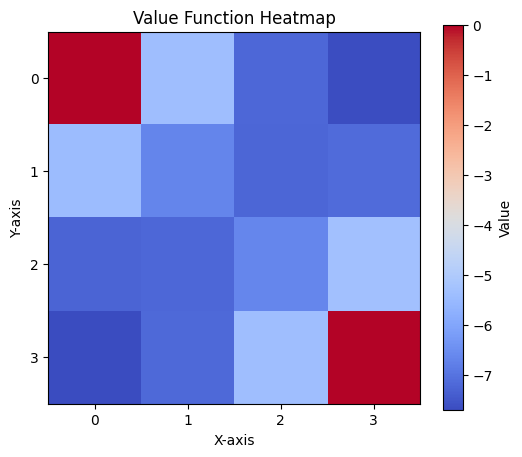

In [15]:
def plot_value_heatmap(V, grid_shape, title="Value Function Heatmap"):
    """Plots a heatmap of the value function."""
    heatmap = np.zeros(grid_shape)
    for (x, y), value in V.items():
        heatmap[x, y] = value

    plt.figure(figsize=(6, 5))
    plt.title(title)
    plt.imshow(heatmap, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label='Value')
    plt.xticks(np.arange(grid_shape[1]))
    plt.yticks(np.arange(grid_shape[0]))
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()

env = GridWorldEnv()
random_policy = lambda state: np.random.choice(env.n_actions)
V = mc_prediction(env, random_policy)
plot_value_heatmap(V, env.grid_shape)

#### **MC Control: Finding $\pi^*$**

In [9]:
def epsilon_greedy_policy(Q, state, n_actions, epsilon=0.1):
    """Epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.choice(n_actions)
    else:
        return np.argmax(Q[state])

def mc_control(env, episodes=5000, gamma=0.9, epsilon=0.1):
    """Monte Carlo Control using epsilon-greedy policy."""
    Q = defaultdict(lambda: np.zeros(env.n_actions))
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)

    for _ in range(episodes):
        episode = []
        state = env.reset()
        done = False

        while not done:
            action = epsilon_greedy_policy(Q, state, env.n_actions, epsilon)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state

        G = 0
        visited = set()
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = gamma * G + reward
            if (state, action) not in visited:
                visited.add((state, action))
                returns_sum[(state, action)] += G
                returns_count[(state, action)] += 1
                Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]

    policy = {state: np.argmax(actions) for state, actions in Q.items()}
    return Q, policy

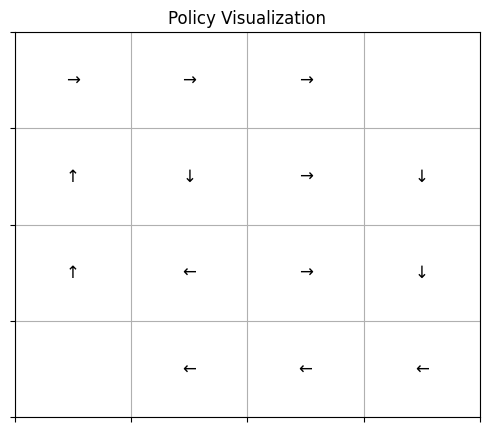

In [21]:
def plot_policy(policy, grid_shape, title="Policy Visualization"):
    """Plots the policy as arrows in a grid."""
    direction_map = {0: '↑', 1: '→', 2: '↓', 3: '←'}
    policy_grid = np.empty(grid_shape, dtype=str)

    for (x, y), action in policy.items():
        policy_grid[x, y] = direction_map[action]

    fig, ax = plt.subplots(figsize=(6, 5))
    ax.set_title(title)
    for (i, j), val in np.ndenumerate(policy_grid):
        ax.text(j, i, val, ha='center', va='center', fontsize=12)
    ax.set_xticks(np.arange(-0.5, grid_shape[1], 1))
    ax.set_yticks(np.arange(-0.5, grid_shape[0], 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True)
    plt.show()

# Example Usage
Q, optimal_policy = mc_control(env)
plot_policy(optimal_policy, env.grid_shape)

**Example Workflow**

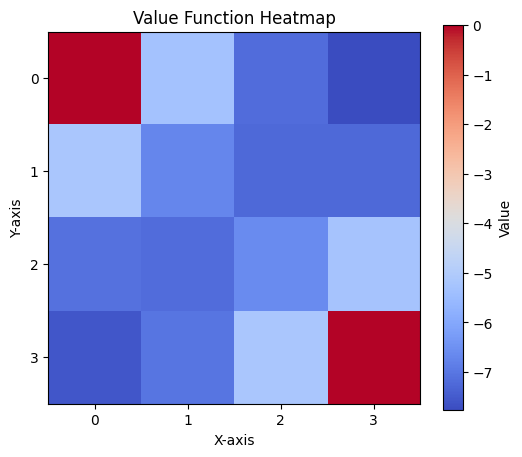

In [25]:
env = GridWorldEnv(grid_shape=(4, 4))
random_policy = lambda state: np.random.choice(env.action_space.n)
V = mc_prediction(env, random_policy)
plot_value_heatmap(V, env.grid_shape)

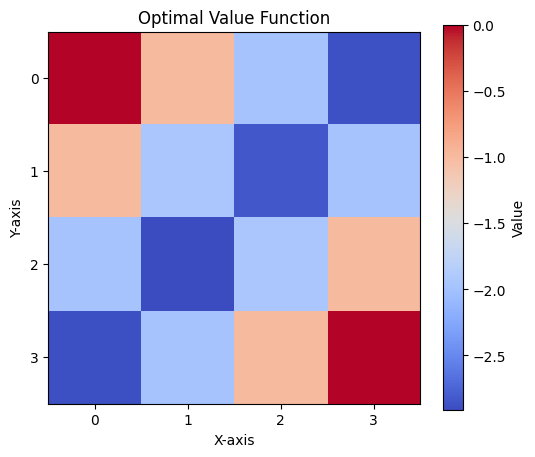

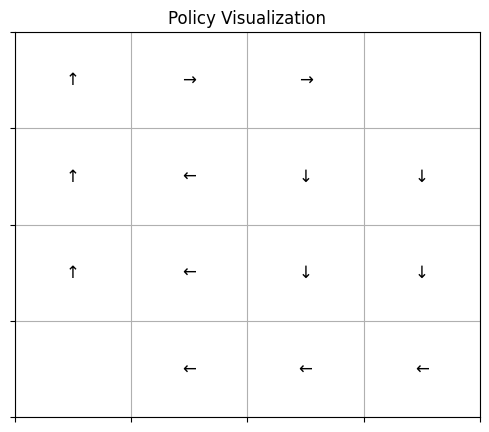

In [26]:
Q, optimal_policy = mc_control(env)
plot_value_heatmap({state: np.max(actions) for state, actions in Q.items()}, env.grid_shape, "Optimal Value Function")
plot_policy(optimal_policy, env.grid_shape)

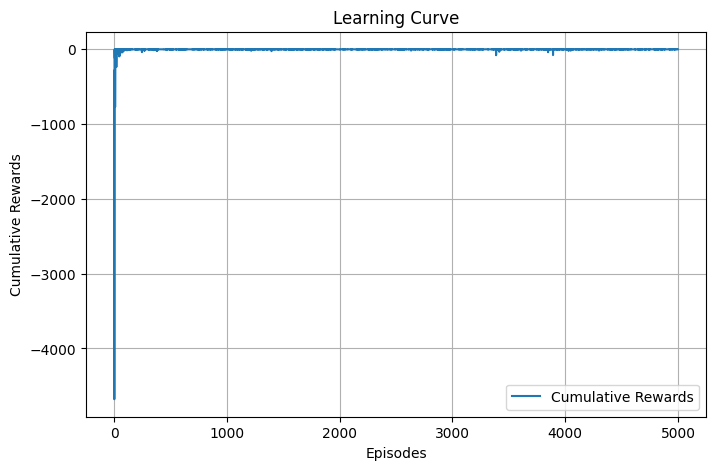

In [28]:
def plot_learning_curve(rewards, title="Learning Curve", ylabel="Cumulative Rewards"):
    """Plots cumulative rewards over episodes."""
    plt.figure(figsize=(8, 5))
    plt.plot(rewards, label='Cumulative Rewards')
    plt.title(title)
    plt.xlabel('Episodes')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.show()

def mc_control_with_rewards(env, episodes=5000, gamma=0.9, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    cumulative_rewards = []  # To track rewards per episode

    for _ in range(episodes):
        episode = []
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = epsilon_greedy_policy(Q, state, env.action_space.n, epsilon)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            episode.append((state, action, reward))
            state = next_state

        G = 0
        visited = set()
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = gamma * G + reward
            if (state, action) not in visited:
                visited.add((state, action))  # Mark as visited
                # Update the Q-value
                Q[state][action] += (G - Q[state][action]) / (1 + len([x for x in episode if x[:2] == (state, action)]))

        cumulative_rewards.append(total_reward)

    return Q, cumulative_rewards

# Example Usage
env = GridWorldEnv(grid_shape=(4, 4))
Q, cumulative_rewards = mc_control_with_rewards(env, episodes=5000, gamma=0.9, epsilon=0.1)

# Plot the learning curve
plot_learning_curve(cumulative_rewards, title="Learning Curve")

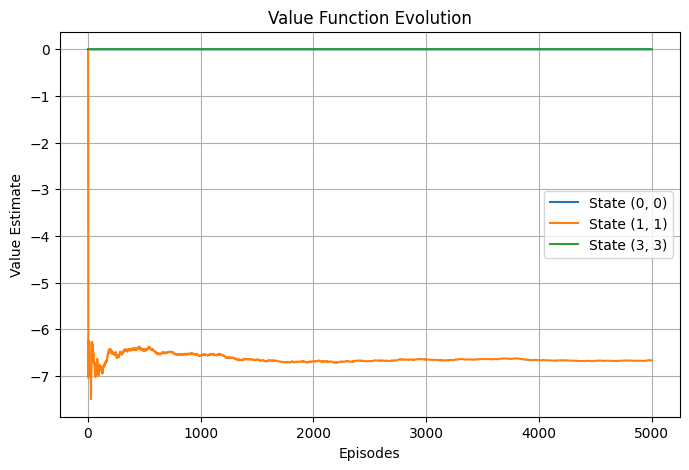

In [29]:
def plot_value_evolution(value_evolution, states_to_track, title="Value Function Evolution"):
    """Plots the evolution of V(s) for specific states over episodes."""
    plt.figure(figsize=(8, 5))
    for state in states_to_track:
        plt.plot(value_evolution[state], label=f"State {state}")
    plt.title(title)
    plt.xlabel('Episodes')
    plt.ylabel('Value Estimate')
    plt.grid(True)
    plt.legend()
    plt.show()

def mc_prediction_track_values(env, policy, episodes=5000, gamma=0.9, states_to_track=[(0, 0), (3, 3)]):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)
    V = defaultdict(float)
    value_evolution = {state: [] for state in states_to_track}

    for _ in range(episodes):
        episode = generate_episode(env, policy)
        G = 0
        for t in reversed(range(len(episode))):
            state, _, reward = episode[t]
            G = gamma * G + reward
            if state not in [x[0] for x in episode[:t]]:
                returns_sum[state] += G
                returns_count[state] += 1
                V[state] = returns_sum[state] / returns_count[state]

        for state in states_to_track:
            value_evolution[state].append(V[state])

    return V, value_evolution

# Run MC Prediction and track value evolution
random_policy = lambda state: np.random.choice(env.action_space.n)
V, value_evolution = mc_prediction_track_values(env, random_policy, states_to_track=[(0, 0), (1, 1), (3, 3)])
plot_value_evolution(value_evolution, states_to_track=[(0, 0), (1, 1), (3, 3)])

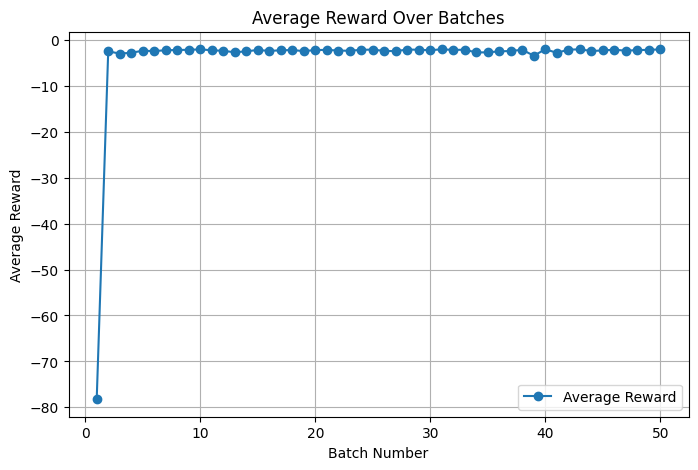

In [30]:
def plot_average_rewards(rewards, batch_size=100, title="Average Reward Over Batches"):
    """Plots the average reward per batch of episodes."""
    batch_means = [np.mean(rewards[i:i+batch_size]) for i in range(0, len(rewards), batch_size)]
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(batch_means) + 1), batch_means, marker='o', label='Average Reward')
    plt.title(title)
    plt.xlabel('Batch Number')
    plt.ylabel('Average Reward')
    plt.grid(True)
    plt.legend()
    plt.show()

# Calculate average rewards over batches
plot_average_rewards(cumulative_rewards)

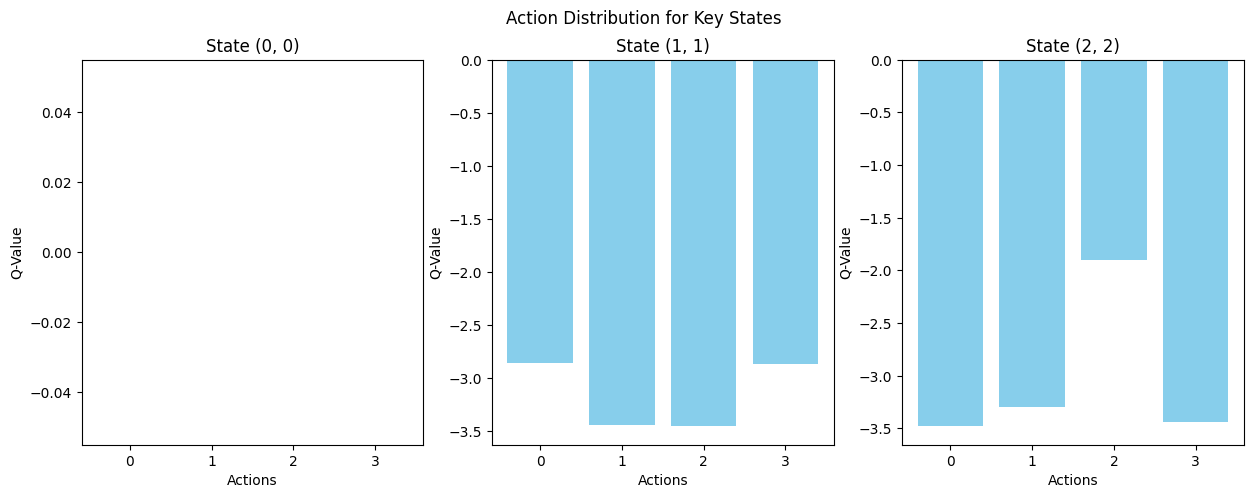

In [31]:
def plot_action_distribution(Q, states, n_actions, title="Action Distribution for Key States"):
    """Plots the action distribution for specific states."""
    fig, axes = plt.subplots(1, len(states), figsize=(15, 5))
    for i, state in enumerate(states):
        actions = Q[state]
        axes[i].bar(range(n_actions), actions, color='skyblue')
        axes[i].set_title(f"State {state}")
        axes[i].set_xlabel("Actions")
        axes[i].set_ylabel("Q-Value")
    plt.suptitle(title)
    plt.show()

# Plot action distributions for key states
plot_action_distribution(Q, states=[(0, 0), (1, 1), (2, 2)], n_actions=env.action_space.n)